<a href="https://colab.research.google.com/github/payaljain2003/NLP/blob/main/Udemy_mem_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import re
import tarfile

In [3]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop
import tensorflow as tf
#from tf.keras.utils import get_file
#from keras.utils.data_utils import get_file

In [4]:
path = tf.keras.utils.get_file(
  'babi-tasks-v1-2.tar.gz',
  origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)


11745123/11745123 [==============================] - 0s 0us/step


In [5]:
challenges = {
  # QA1 with 10,000 samples
  'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
  # QA2 with 10,000 samples
  'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}

In [23]:
def tokenize(sent):
  print(sent)
  tokens = re.split(r'\W+', sent)
  return [x.strip() for x in tokens if x.strip()]

In [7]:
def get_stories(f):
  data = []
  story = []

  printed = False
  for line in f:
    line = line.decode('utf-8').strip()

    nid, line = line.split(" ", 1)

    if int(nid) == 1:
      story = []

    if'\t' in line:
      q,a,supporting = line.split('\t')
      q = tokenize(q)


      story_so_far = [[str(i)] + s for i,s in enumerate(story) if s]

      data.append((story_so_far, q, a))
      story.append('')

    else:
      story.append(tokenize(line))

  return data


In [8]:
def should_flatten(el):
  return not isinstance(el, (str, bytes))

def flatten(l):
  for el in l:
    if should_flatten(el):
      yield from flatten(el)
    else:
      yield el


In [9]:
def vectorize_stories(data, word2idx, story_maxlen, query_maxlen):
  inputs,queries, answers = [],[],[]

  for story, query, answer in data:
    inputs.append([[word2idx[w] for w in s] for s in story])
    queries.append([word2idx[w] for w in query])
    answers.append([word2idx[answer]])
  return(
      [pad_sequences(x, maxlen = story_maxlen) for x in inputs],
      pad_sequences(queries, maxlen = query_maxlen),
      np.array(answers)
  )

In [10]:
def stack_inputs(inputs, story_maxsents, story_maxlen):
  for i , story in enumerate(inputs):
    inputs[i] = np.concatenate(
        [
            story,
            np.zeros((story_maxsents - story.shape[0],story_maxlen ), 'int')
        ]
    )
  return np.stack(inputs)

In [11]:
def get_data(challenge_type):
  challenge = challenges[challenge_type]

  train_stories = get_stories(tar.extractfile(challenge.format('train')))
  test_stories = get_stories(tar.extractfile(challenge.format('test')))


  stories = train_stories + test_stories

  story_maxlen = max((len(s) for x,_,_ in stories for s in x))
  story_maxsents = max((len(x) for x,_,_ in stories))
  query_maxlen = max(len(x) for _,x,_ in stories)


  vocab = sorted(set(flatten(stories)))
  vocab.insert(0,'<PAD>')
  vocab_size = len(vocab)


  word2idx = {c : i for i,c in enumerate(vocab)}


  inputs_train, queries_train, answers_train = vectorize_stories(
   train_stories,
   word2idx,
   story_maxlen,
   query_maxlen
   )


  inputs_test, queries_test, answers_test = vectorize_stories(
   test_stories,
   word2idx,
   story_maxlen,
   query_maxlen
   )


  inputs_train = stack_inputs(inputs_train, story_maxsents, story_maxlen)
  inputs_test = stack_inputs(inputs_test, story_maxsents, story_maxlen)


  print("inputs_train.shape, inputs_test.shape",inputs_train.shape, inputs_test.shape)


  return train_stories, test_stories, inputs_train, queries_train, answers_train, inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, vocab, vocab_size

In [24]:
train_stories, test_stories, inputs_train, queries_train, answers_train, inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, vocab, vocab_size = get_data('single_supporting_fact_10k')

Streaming output truncated to the last 5000 lines.
Where is Sandra? 
Mary went to the kitchen.
Mary went back to the hallway.
Where is John? 
Sandra journeyed to the garden.
John went to the office.
Where is Sandra? 
Mary went back to the bathroom.
Mary went back to the bedroom.
Where is Mary? 
Daniel went to the hallway.
John journeyed to the bedroom.
Where is John? 
Sandra journeyed to the bedroom.
John moved to the garden.
Where is Daniel? 
John journeyed to the bathroom.
Mary went to the garden.
Where is Mary? 
Sandra went to the bathroom.
Sandra moved to the office.
Where is Sandra? 
Mary journeyed to the bathroom.
Daniel went back to the office.
Where is Sandra? 
Daniel journeyed to the garden.
Sandra went to the bathroom.
Where is Sandra? 
Mary journeyed to the office.
Sandra moved to the kitchen.
Where is Daniel? 
Daniel moved to the bathroom.
John went back to the garden.
Where is Sandra? 
Sandra journeyed to the hallway.
Mary travelled to the kitchen.
Where is Mary? 
Mary jou

In [25]:
embedding_dim = 15
input_story_ = Input((story_maxsents, story_maxlen))
embedded_story = Embedding(vocab_size, embedding_dim)(input_story_)
embedded_story = Lambda(lambda x : K.sum(x, axis = 2))(embedded_story)
print("input_story_.shape, embedded_story.shape",input_story_.shape, embedded_story.shape )


input_story_.shape, embedded_story.shape (None, 10, 7) (None, 10, 15)


In [26]:
input_question_ = Input((query_maxlen,))
embedded_question = Embedding(vocab_size, embedding_dim)(input_question_)
embedded_question = Lambda(lambda x: K.sum(x, axis=1))(embedded_question)

In [27]:
embedded_question = Reshape((1, embedding_dim))(embedded_question)
print("inp_q.shape, emb_q.shape:", input_question_.shape, embedded_question.shape)

inp_q.shape, emb_q.shape: (None, 3) (None, 1, 15)


In [28]:
x = dot([embedded_story, embedded_question], 2)
x = Reshape((story_maxsents,))(x) # flatten the vector
x = Activation('softmax')(x)
story_weights = Reshape((story_maxsents, 1))(x) # unflatten it again to be dotted later
print("story_weights.shape:", story_weights.shape)

story_weights.shape: (None, 10, 1)


In [29]:
x = dot([story_weights, embedded_story], 1)
x = Reshape((embedding_dim,))(x) # flatten it again
ans = Dense(vocab_size, activation='softmax')(x)


In [30]:
model = Model([input_story_, input_question_], ans)

In [32]:
model.compile(
  optimizer=RMSprop(lr=1e-2),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# train the model
r = model.fit(
  [inputs_train, queries_train],
  answers_train,
  epochs=4,
  batch_size=32,
  validation_data=([inputs_test, queries_test], answers_test)
)


# Check how we weight each input sentence given a story and question
debug_model = Model([input_story_, input_question_], story_weights)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w = debug_model.predict([i, q]).flatten()

story, question, ans = train_stories[story_idx]
print("story:\n")
for i, line in enumerate(story):
  print("{:1.5f}".format(w[i]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)


# pause so we can see the output
input("Hit enter to continue\n\n")

Epoch 1/4
313/313 [==============================] - 2s 4ms/step - loss: 0.5972 - accuracy: 0.8662 - val_loss: 0.3906 - val_accuracy: 0.9170
Epoch 2/4
313/313 [==============================] - 1s 4ms/step - loss: 0.2199 - accuracy: 0.9700 - val_loss: 0.1148 - val_accuracy: 0.9940
Epoch 3/4
313/313 [==============================] - 1s 4ms/step - loss: 0.0575 - accuracy: 0.9990 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 4/4
1/1 [==============================] - 0s 93ms/step
story:

0.78886 	 0 Daniel went to the bedroom
0.02091 	 1 Mary travelled to the bathroom
0.04428 	 3 John went back to the kitchen
0.14541 	 4 John travelled to the hallway
question: Where is Daniel
answer: bedroom
Hit enter to continue




''

Streaming output truncated to the last 5000 lines.
Sandra travelled to the office.
Mary grabbed the milk there.
Where is the apple? 
John went to the kitchen.
Mary moved to the hallway.
Where is the milk? 
Sandra discarded the apple.
Mary left the milk.
Where is the milk? 
Mary took the milk there.
Mary left the milk.
Where is the milk? 
John got the football there.
John moved to the hallway.
Where is the milk? 
Daniel moved to the bedroom.
Daniel went to the bathroom.
John moved to the garden.
Mary travelled to the bedroom.
Sandra travelled to the garden.
Daniel journeyed to the garden.
Sandra travelled to the hallway.
John got the football there.
John moved to the bathroom.
Sandra travelled to the bathroom.
Where is the football? 
Daniel moved to the bedroom.
Daniel travelled to the kitchen.
Where is the football? 
Mary moved to the hallway.
Sandra travelled to the office.
Daniel moved to the hallway.
Daniel went back to the kitchen.
John went back to the hallway.
Daniel went back to

Epoch 1/30
313/313 [==============================] - 7s 18ms/step - loss: 2.0919 - accuracy: 0.1698 - val_loss: 1.7949 - val_accuracy: 0.1750
Epoch 2/30
313/313 [==============================] - 4s 13ms/step - loss: 1.7989 - accuracy: 0.1657 - val_loss: 1.8140 - val_accuracy: 0.1670
Epoch 3/30
313/313 [==============================] - 4s 13ms/step - loss: 1.7979 - accuracy: 0.1641 - val_loss: 1.7989 - val_accuracy: 0.1870
Epoch 4/30
313/313 [==============================] - 5s 15ms/step - loss: 1.7892 - accuracy: 0.1897 - val_loss: 1.7822 - val_accuracy: 0.1710
Epoch 5/30
313/313 [==============================] - 4s 13ms/step - loss: 1.7022 - accuracy: 0.3047 - val_loss: 1.6345 - val_accuracy: 0.3310
Epoch 6/30
313/313 [==============================] - 4s 12ms/step - loss: 1.5694 - accuracy: 0.3699 - val_loss: 1.5184 - val_accuracy: 0.3680
Epoch 7/30
313/313 [==============================] - 5s 16ms/step - loss: 1.4882 - accuracy: 0.3874 - val_loss: 1.4699 - val_accuracy: 0.3740

1/1 [==============================] - 0s 167ms/step
story:

0.00000 	 0.06635 	 0 Sandra went back to the kitchen
0.00000 	 0.00039 	 1 Sandra picked up the apple there
0.00000 	 0.11542 	 2 John went back to the kitchen
0.00000 	 0.00026 	 3 John grabbed the football there
0.00000 	 0.15082 	 4 Mary went back to the hallway
0.00000 	 0.17350 	 5 Daniel journeyed to the bedroom
0.00001 	 0.05581 	 6 Sandra discarded the apple
0.00000 	 0.20090 	 7 John journeyed to the bathroom
0.00000 	 0.22730 	 9 John journeyed to the office
0.00001 	 0.00840 	 10 John dropped the football
question: Where is the apple
answer: kitchen


1/1 [==============================] - 0s 188ms/step
prediction: bathroom


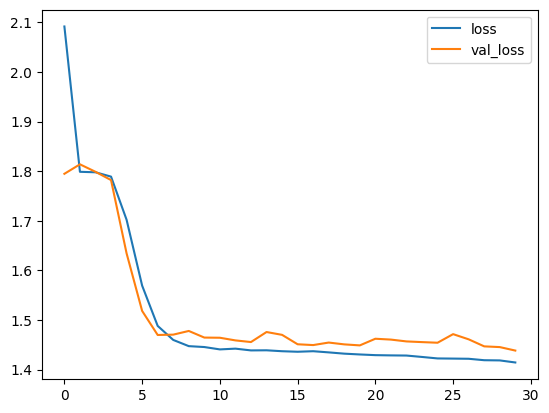

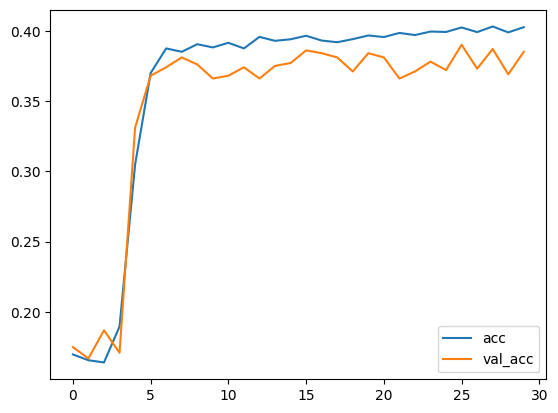

In [34]:
# get the two supporting fact data
train_stories, test_stories, \
  inputs_train, queries_train, answers_train, \
  inputs_test, queries_test, answers_test, \
  story_maxsents, story_maxlen, query_maxlen, \
  vocab, vocab_size = get_data('two_supporting_facts_10k')

##### create the model #####
embedding_dim = 30


# make a function for this so we can use it again
def embed_and_sum(x, axis=2):
  x = Embedding(vocab_size, embedding_dim)(x)
  x = Lambda(lambda x: K.sum(x, axis))(x)
  return x

# define the inputs
input_story_ = Input((story_maxsents, story_maxlen))
input_question_ = Input((query_maxlen,))


# embed the inputs
embedded_story = embed_and_sum(input_story_)
embedded_question = embed_and_sum(input_question_, 1)


# final dense will be used in each hop
dense_layer = Dense(embedding_dim, activation='elu')


# define one hop
# the "query" can be the question, or the answer from the previous hop
def hop(query, story):
  # query.shape = (embedding_dim,)
  # story.shape = (num sentences, embedding_dim)
  x = Reshape((1, embedding_dim))(query) # make it (1, embedding_dim)
  x = dot([story, x], 2)
  x = Reshape((story_maxsents,))(x) # flatten it for softmax
  x = Activation('softmax')(x)
  story_weights = Reshape((story_maxsents, 1))(x) # unflatten for dotting

  # makes a new embedding
  story_embedding2 = embed_and_sum(input_story_)
  x = dot([story_weights, story_embedding2], 1)
  x = Reshape((embedding_dim,))(x)
  x = dense_layer(x)
  return x, story_embedding2, story_weights


# do the hops
ans1, embedded_story, story_weights1 = hop(embedded_question, embedded_story)
ans2, _,              story_weights2 = hop(ans1,              embedded_story)

# get the final answer
ans = Dense(vocab_size, activation='softmax')(ans2)


# build the model
model2 = Model([input_story_, input_question_], ans)

# compile the model
model2.compile(
  optimizer=RMSprop(lr=5e-3),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# fit the model
r = model2.fit(
  [inputs_train, queries_train],
  answers_train,
  epochs=30,
  batch_size=32,
  validation_data=([inputs_test, queries_test], answers_test)
)


### print story line weights again ###
debug_model2 = Model(
  [input_story_, input_question_],
  [story_weights1, story_weights2]
)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w1, w2 = debug_model2.predict([i, q])
w1 = w1.flatten()
w2 = w2.flatten()

story, question, ans = train_stories[story_idx]
print("story:\n")
for j, line in enumerate(story):
  print("{:1.5f}".format(w1[j]), "\t", "{:1.5f}".format(w2[j]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)
print("prediction:", vocab[ np.argmax(model2.predict([i, q])[0]) ])


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
